<a href="https://colab.research.google.com/github/Sofismarilla/PatientVisitsForecasting/blob/main/ARIMA_Patient_Visits_Forecasting_for_Allocation_Decision_of_Healthcare_%5BGroupTestA%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multivariate Time Series Forecasting using ARIMA Model based on Patient Visits Medical Laboratory Data (GroupTestA)**

## **Step#0 Fire System**

In [1]:
!pip install pmdarima
!pip install shap
!pip install --upgrade mxnet~=1.7 gluonts
!pip install python-utils
!pip install plotly==4.1.0
!pip install -U scikit-learn
!pip install statsmodels
!pip install --user scipy==1.2.0
!pip install -U statsmodels

     |████████████████████████████████| 1.5MB 4.3MB/s 
     |████████████████████████████████| 9.5MB 34.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 358kB 4.2MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491628 sha256=c740fc65efb04ac19e96e8f6e59b7daa88eeb5932c9580a77eeee5cd8782a371
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
     |████████████████████████████████| 46.9MB 63kB/s 
     |████████████████████████████████| 901kB 34.2MB/s 
     |████████████████████████████████| 10.1MB 34.2MB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 7.1MB 4.4MB/s 
ERROR: cufflinks 0.17.3 has requirement plotly>=4.1.1, b

In [2]:
import warnings
import numpy as np
import pandas as pd

# Data visualization
import folium
import datetime
%matplotlib inline
import seaborn as sns 
import matplotlib as mpl
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.ticker as tkr
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from IPython.display import display, HTML, display_html

# Method Requirement
import keras
import sklearn
import tensorflow as tf
from keras.layers import *
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Statistics 
import scipy
from math import sqrt
from time import time
from scipy import stats
import statsmodels as sms
from timeit import default_timer as timer
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set_style('white')
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = False
sns.set_context("paper", font_scale=1.3)
plt.rcParams['figure.figsize'] = (10, 8)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## **Step#1 Input Data**

In [3]:
data = pd.read_csv('/content/drive/MyDrive/THESIS/Dataset/dateset_patient.csv')

In [4]:
data.head()

,date,hm,hm_aw,hm_am,cc,cc_aw,cc_am,day_week
0,7/1/2017,66,48,63,44,37,45,6
1,7/2/2017,53,53,62,72,37,43,7
2,7/3/2017,74,54,59,87,42,44,1
3,7/4/2017,87,56,57,58,49,44,2
4,7/5/2017,95,62,58,72,53,44,3


## **Step#2 Data Processing**

### **Picking Variable**

In [5]:
data["date"] = pd.to_datetime(data["date"], format = '%m/%d/%Y')
df = data.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

In [6]:
hm = df['hm'].fillna(df['hm'].mean())
hm_aw = df['hm_aw'].fillna(df['hm'].mean())
hm_am = df['hm_am'].fillna(df['hm'].mean())
day_week = df['day_week'].fillna(df['hm'].mean())

In [7]:
df_hm = pd.DataFrame({'hm':hm, 'hm_aw':hm_aw, 'hm_am':hm_am, 'day_week':day_week})
df.to_csv("hm.csv")
df_hm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1348 entries, 0 to 1347
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   hm        1348 non-null   int64
 1   hm_aw     1348 non-null   int64
 2   hm_am     1348 non-null   int64
 3   day_week  1348 non-null   int64
dtypes: int64(4)
memory usage: 42.2 KB


In [8]:
df_hm.head()

,hm,hm_aw,hm_am,day_week
0,66,48,63,6
1,53,53,62,7
2,74,54,59,1
3,87,56,57,2
4,95,62,58,3


### **Stationary Test**

In [9]:
result1 = adfuller(df_hm['hm'].dropna())
result2 = adfuller(df_hm['hm_aw'].dropna())
result3 = adfuller(df_hm['hm_am'].dropna())
result4 = adfuller(df_hm['day_week'].dropna())

print("hm")
print("ADF Statistics",result1[0])
print("p-value",result1[1])
print("critical values",result1[5])
if result1[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("hm_aw")   
print("ADF Statistics",result2[0])
print("p-value",result2[1])
print("critical values",result2[5])
if result2[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("hm_am")   
print("ADF Statistics",result3[0])
print("p-value",result3[1])
print("critical values",result2[5])
if result3[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("day_week")   
print("ADF Statistics",result4[0])
print("p-value",result4[1])
print("critical values",result2[5])
if result4[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

hm
ADF Statistics -2.5335082015543278
p-value 0.10753279625420847
critical values 10741.023212534707
Reject the null hypotheise , it mean data is not stationary
hm_aw
ADF Statistics -2.7085997612714094
p-value 0.07256192046723037
critical values 5737.34541423982
Reject the null hypotheise , it mean data is not stationary
hm_am
ADF Statistics -2.801936215872385
p-value 0.05799772524150528
critical values 5737.34541423982
Reject the null hypotheise , it mean data is not stationary
day_week
ADF Statistics -7.227305775197777e-12
p-value 0.9585320860594583
critical values 5737.34541423982
Reject the null hypotheise , it mean data is not stationary


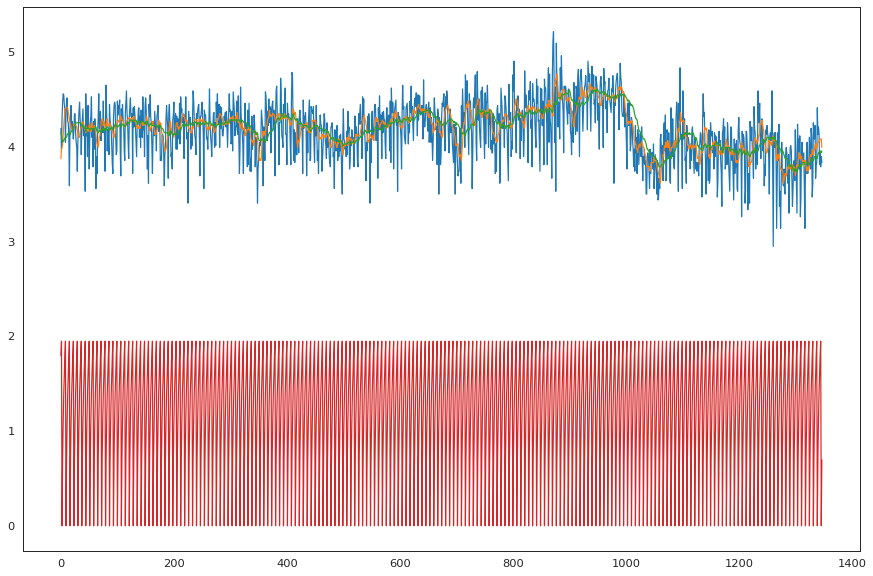

In [10]:
rcParams['figure.figsize'] = 15,10
#Estimate trend
df_hm_logScale = np.log(df_hm)
plt.plot(df_hm_logScale)

### **Differencing**

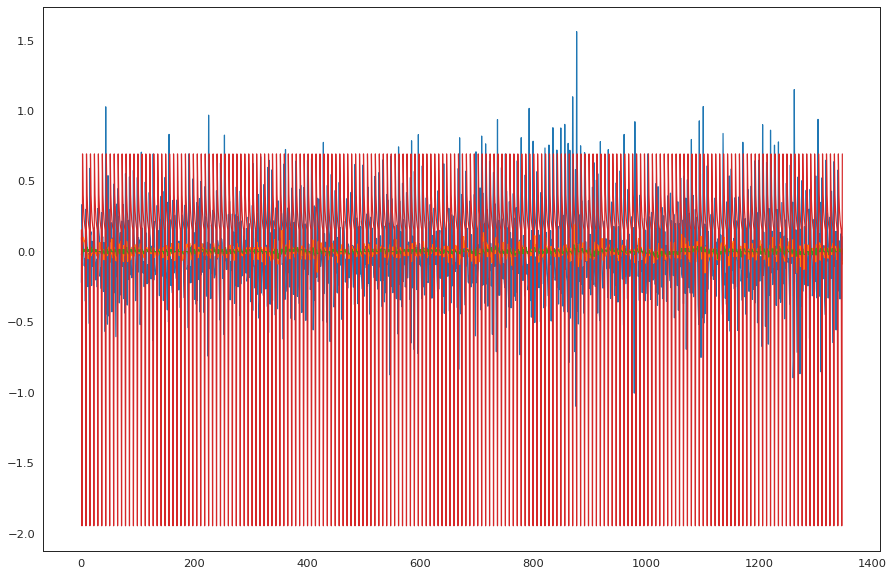

In [11]:
dfLogDiff = df_hm_logScale-df_hm_logScale.shift()
dfLogDiff.dropna(inplace=True)
plt.plot(dfLogDiff)

In [12]:
result1 = adfuller(dfLogDiff['hm'].dropna())
result2 = adfuller(dfLogDiff['hm_aw'].dropna())
result3 = adfuller(dfLogDiff['hm_am'].dropna())
result4 = adfuller(dfLogDiff['day_week'].dropna())

print("hm")
print("ADF Statistics",result1[0])
print("p-value",result1[1])
print("critical values",result1[5])
if result1[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("hm_aw")   
print("ADF Statistics",result2[0])
print("p-value",result2[1])
print("critical values",result2[5])
if result2[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("hm_am")   
print("ADF Statistics",result3[0])
print("p-value",result3[1])
print("critical values",result2[5])
if result3[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

print("day_week")   
print("ADF Statistics",result4[0])
print("p-value",result4[1])
print("critical values",result2[5])
if result4[1]<=0.05:
    print("fail to reject null hypothese h1 , it mean data is stationary")
else:
    print("Reject the null hypotheise , it mean data is not stationary")


print("===================================================================")

hm
ADF Statistics -13.576780315601706
p-value 2.1619404960812895e-25
critical values -352.26935868416876
fail to reject null hypothese h1 , it mean data is stationary
hm_aw
ADF Statistics -8.91325491567722
p-value 1.0898293013157196e-14
critical values -5386.752576316653
fail to reject null hypothese h1 , it mean data is stationary
hm_am
ADF Statistics -5.7038747674686165
p-value 7.56641782440971e-07
critical values -5386.752576316653
fail to reject null hypothese h1 , it mean data is stationary
day_week
ADF Statistics -6998132379707925.0
p-value 0.0
critical values -5386.752576316653
fail to reject null hypothese h1 , it mean data is stationary


### **Autocorrelation, ACF and PACF Plots**

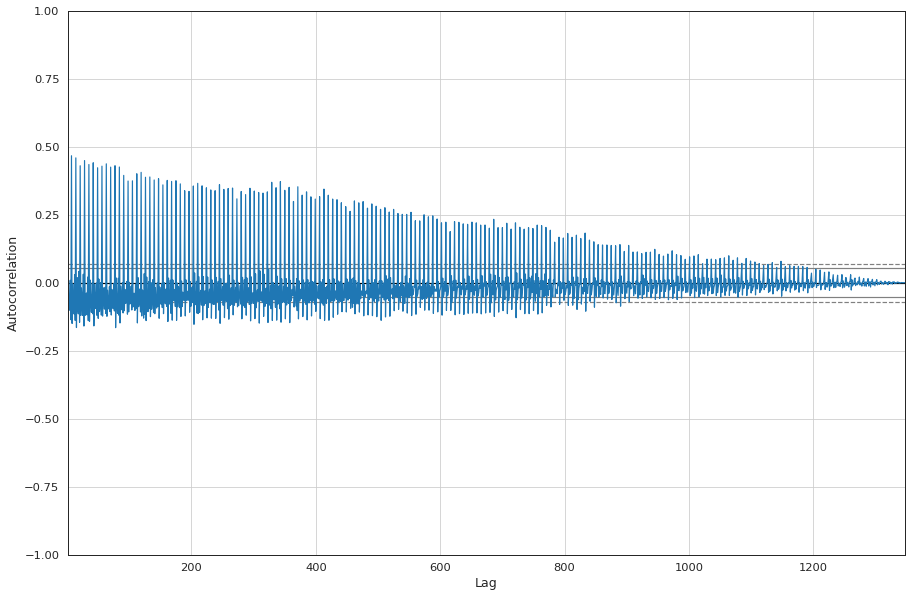

In [13]:
# from pandas.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot

acf_pcf = dfLogDiff['hm'].astype(float)
autocorrelation_plot(acf_pcf)

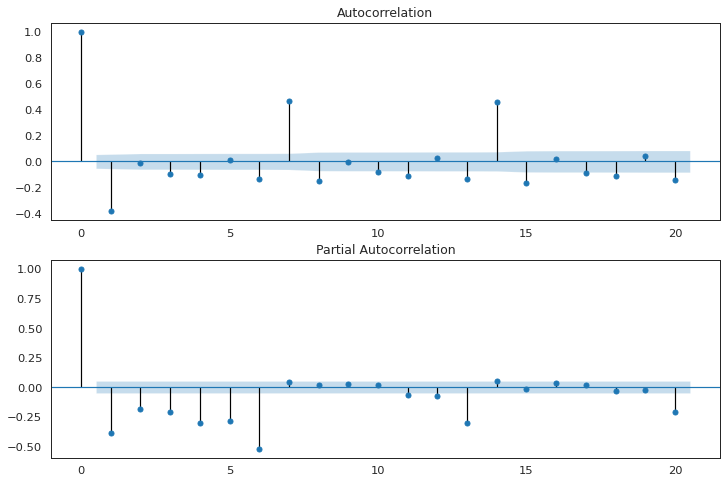

In [14]:
#2 plots on one sheet

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(acf_pcf, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(acf_pcf, lags=20, ax=ax2)

#blue color means the boundaries of the 95% confidence interval
#if bar ranges outside the boundaries, we can assume that the lag has autocorrelation

## **Step#3 Fitting and Training Model**

Text(0.5, 1.0, 'RSS: 86.4051')

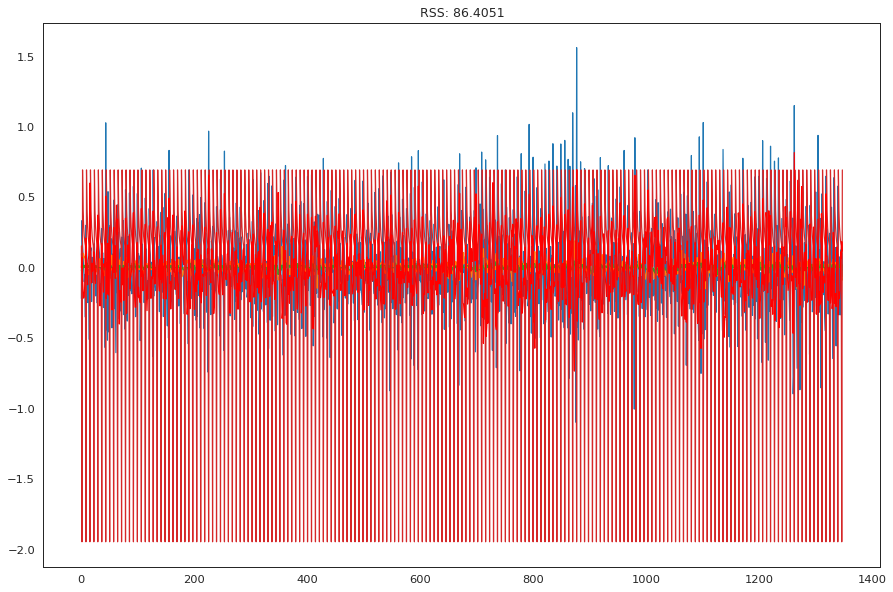

In [15]:
from statsmodels.tsa.arima_model import ARIMA
# Model Order
model = ARIMA(df_hm_logScale['hm'],order=(2, 1, 2))

# Show Result
result_ARIMA= model.fit(disp=-1)
plt.plot(dfLogDiff)
plt.plot(result_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'%sum((result_ARIMA.fittedvalues-dfLogDiff['hm'])**2))

In [16]:
pred_ARIMA = pd.Series(result_ARIMA.fittedvalues,copy=True)
print(pred_ARIMA.head())

1   -0.0003
2    0.0727
3   -0.0782
4   -0.1678
5   -0.2169
dtype: float64


In [17]:
pred_ARIMA_cumsum = pred_ARIMA.cumsum()
print(pred_ARIMA_cumsum.head())

1   -0.0003
2    0.0724
3   -0.0057
4   -0.1735
5   -0.3904
dtype: float64


In [18]:
prediction_ARIMA_log = pd.Series(df_hm_logScale['hm'].iloc[0], index=df_hm_logScale.index)
prediction_ARIMA_log = prediction_ARIMA_log.add(pred_ARIMA_cumsum,fill_value =0)
prediction_ARIMA_log.head()

0   4.1897
1   4.1894
2   4.2621
3   4.1839
4   4.0161
dtype: float64

## **Step#4 Actual vs Prediction Plot and Evaluation Metrics**

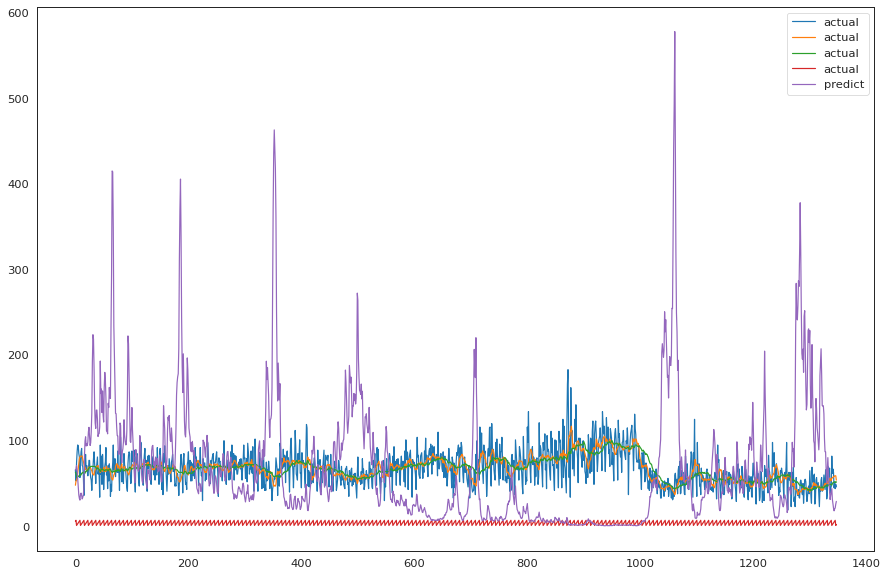

In [19]:
prediction_ARIMA = np.exp(prediction_ARIMA_log)
plt.plot(df_hm, label='actual')
plt.plot(prediction_ARIMA, label='predict')
plt.legend(loc='best')

In [20]:
# MSE and RMSE Score
print('MSE value :', mean_squared_error(hm, prediction_ARIMA))
print('RMSE value  : ', sqrt(mean_squared_error(hm, prediction_ARIMA)))

MSE value : 6533.155777738097
RMSE value  :  80.82793933868471
